
# Modèle supervisé simple : classification binaire avec un MLP

## **Objectifs pédagogiques :**
 - Construire un petit jeu de données annotées (x, y).
 - Définir un modèle paramétré f_θ (petit réseau de neurones).
 - Minimiser une fonction de perte par descente de gradient (Adam).
- Visualiser l'apprentissage : courbe de perte + frontière de décision.

Shape X_train : torch.Size([350, 2])
Shape y_train : torch.Size([350, 1])


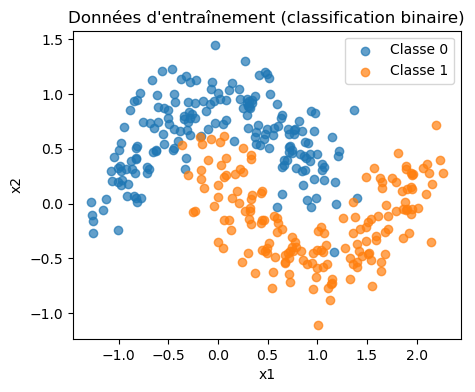

SmallMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)
Epoch  50 | Loss = 0.3121
Epoch 100 | Loss = 0.2378
Epoch 150 | Loss = 0.2061
Epoch 200 | Loss = 0.1718
Epoch 250 | Loss = 0.1391
Epoch 300 | Loss = 0.1155
Epoch 350 | Loss = 0.0999
Epoch 400 | Loss = 0.0898
Epoch 450 | Loss = 0.0832
Epoch 500 | Loss = 0.0779


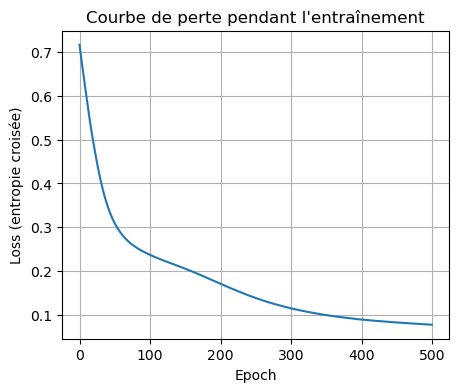

Précision train : 97.14 %
Précision test  : 96.00 %


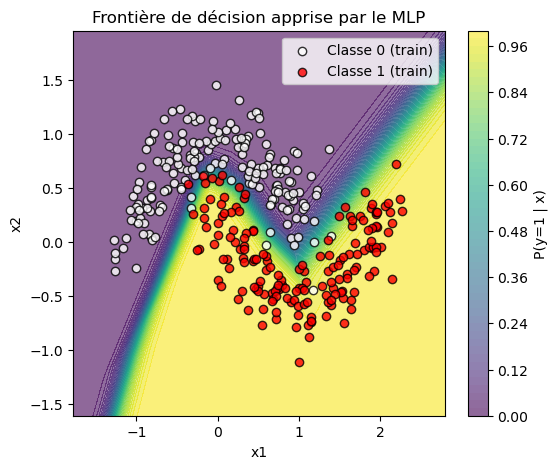

In [1]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

# %%
# =========================
# 1. Génération des données
# =========================
# On crée un petit dataset 2D non-linéaire (deux classes)
X, y = make_moons(n_samples=500, noise=0.2, random_state=0)

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# Conversion en tenseurs PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape (N,1)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print("Shape X_train :", X_train_t.shape)
print("Shape y_train :", y_train_t.shape)

# %%
# Visualisation rapide des données
plt.figure(figsize=(5, 4))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label="Classe 0", alpha=0.7)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label="Classe 1", alpha=0.7)
plt.title("Données d'entraînement (classification binaire)")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# %% [markdown]
# ## 2. Définition du modèle paramétré f_θ
#
# On utilise un petit MLP :
# - Entrée : 2 dimensions (x1, x2)
# - Couche cachée : 16 neurones + ReLU
# - Sortie : 1 logit (avant sigmoïde) pour la probabilité de la classe 1

# %%
class SmallMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # sortie : logit pour la classe 1
        )

    def forward(self, x):
        return self.net(x)


model = SmallMLP()
print(model)

# %%
# =============================
# 3. Fonction de perte et optim
# =============================
# On utilise une entropie croisée binaire avec logits
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# %%
# ============================
# 4. Boucle d'entraînement
# ============================
n_epochs = 500
loss_history = []

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    logits = model(X_train_t)          # shape (N,1)
    loss = criterion(logits, y_train_t)

    loss.backward()                    # ∇_θ L
    optimizer.step()                   # mise à jour des paramètres θ

    loss_history.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Loss = {loss.item():.4f}")

# %%
# Visualisation de la courbe de perte
plt.figure(figsize=(5, 4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss (entropie croisée)")
plt.title("Courbe de perte pendant l'entraînement")
plt.grid(True)
plt.show()

# %% [markdown]
# ## 5. Évaluation : précision sur train et test
#
# On applique une sigmoïde sur la sortie pour obtenir une probabilité.
# Puis on seuille à 0.5 pour obtenir la classe prédite.

# %%
def accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        correct = (preds == y).float().mean().item()
    return correct


train_acc = accuracy(model, X_train_t, y_train_t)
test_acc = accuracy(model, X_test_t, y_test_t)

print(f"Précision train : {train_acc*100:.2f} %")
print(f"Précision test  : {test_acc*100:.2f} %")

# %% [markdown]
# ## 6. Visualisation de la frontière de décision
#
# Objectif pédagogique :
# - Relier le modèle abstrait f_θ à une frontière de décision concrète en 2D.
# - Montrer que le MLP apprend une séparation non linéaire entre les classes.

# %%
# Création d'une grille 2D couvrant les données
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_t = torch.tensor(grid, dtype=torch.float32)

# Prédictions sur la grille
model.eval()
with torch.no_grad():
    logits_grid = model(grid_t)
    probs_grid = torch.sigmoid(logits_grid).reshape(xx.shape)

# Plot de la frontière
plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, probs_grid, levels=50, alpha=0.6)
plt.colorbar(label="P(y=1 | x)")

# Points d'entraînement
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
            edgecolor="k", facecolor="white", label="Classe 0 (train)", alpha=0.8)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
            edgecolor="k", facecolor="red", label="Classe 1 (train)", alpha=0.8)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Frontière de décision apprise par le MLP")
plt.legend()
plt.show()
